In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from loguru import logger
from datetime import datetime
from pathlib import Path
import os
from tqdm import tqdm
import time
import json
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as snspy 
import editdistance
from lab3_evaluate import *

In [10]:
## reload model
resume_version = 'trained-net-20240507-001102-trainacc-57.58-valacc-51.77-testacc-50.87'
resume_ckpt_path = f'output/{resume_version}.pt'

config_file = f'output/{resume_version}.json'
config = json.load(open(config_file, 'rb'))

stateList = np.load('state_list.npy').tolist()
num_cls = len(stateList)

input_size = config['input_size']
hidden_layer_list = config['hidden_layer_list']
activate_func = config['activate_func']
use_dynamic_features = config['use_dynamic_features']
feature_type = config['feature_type']
batch_size = 1024

In [15]:
# initiate
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
net = Net(input_size=input_size, num_cls=num_cls, hidden_layer_list=hidden_layer_list, activate_func=activate_func)
net = net.to(device)

#print(os.path.exists(resume_ckpt_path))
state_dict = torch.load(resume_ckpt_path, map_location='cpu')  
#state_dict = torch.load(resume_ckpt_path)
net.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
# reload data
prepared_data_test = np.load('prepared_test_data.npz')
if use_dynamic_features:
    np_test_x = prepared_data_test[f'data_x_dynamic_{feature_type}']
    np_test_y = prepared_data_test['data_y']
else:
    np_test_x = prepared_data_test[f'data_x_{feature_type}']
    np_test_y = prepared_data_test['data_y']
test_x = torch.tensor(np_test_x)
test_y = F.one_hot(torch.tensor(np_test_y, dtype=torch.long), num_classes=num_cls).float()
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
net.eval()
test_cnt = 0
logger.info('Testing...')
all_outputs = np.zeros(len(test_dataset))
all_labels = np.zeros(len(test_dataset))
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        all_outputs[test_cnt:test_cnt+len(outputs)] = torch.max(torch.softmax(outputs, dim=1), dim=1)[1].cpu().numpy()
        all_labels[test_cnt:test_cnt+len(outputs)] = torch.max(labels, dim=1)[1].cpu().numpy()
        test_cnt += len(inputs)

2024-05-12 15:22:25.758 | INFO     | __main__:<module>:3 - Testing...
100%|██████████| 1492/1492 [00:17<00:00, 87.56it/s]


## 5.1.1 frame-by-frame at the state level

In [18]:
correct_cnt = 0
for idx in tqdm(range(len(all_outputs))):
    output = all_outputs[idx]
    label = all_labels[idx]
    if output == label:
        correct_cnt += 1
test_acc = correct_cnt/len(all_outputs)
logger.info(f'Frame-by-frame at the state level accuracy: {test_acc * 100:.2f}%')
cm = confusion_matrix(all_labels, all_outputs)
logger.info(f"State level confusion matrix:\n{cm}")

100%|██████████| 1527014/1527014 [00:00<00:00, 4626219.93it/s]
2024-05-12 15:24:55.667 | INFO     | __main__:<module>:8 - Frame-by-frame at the state level accuracy: 8.65%
2024-05-12 15:24:56.151 | INFO     | __main__:<module>:10 - State level confusion matrix:
[[184 245 114 ...   0   1  15]
 [202 283 113 ...   0   1  17]
 [176 281 115 ...   0   2  17]
 ...
 [ 54  52  19 ...   2   0  20]
 [ 66  53  20 ...   2   1  22]
 [ 68  60  20 ...   0   0  15]]


Text(95.58159722222221, 0.5, 'True Label')

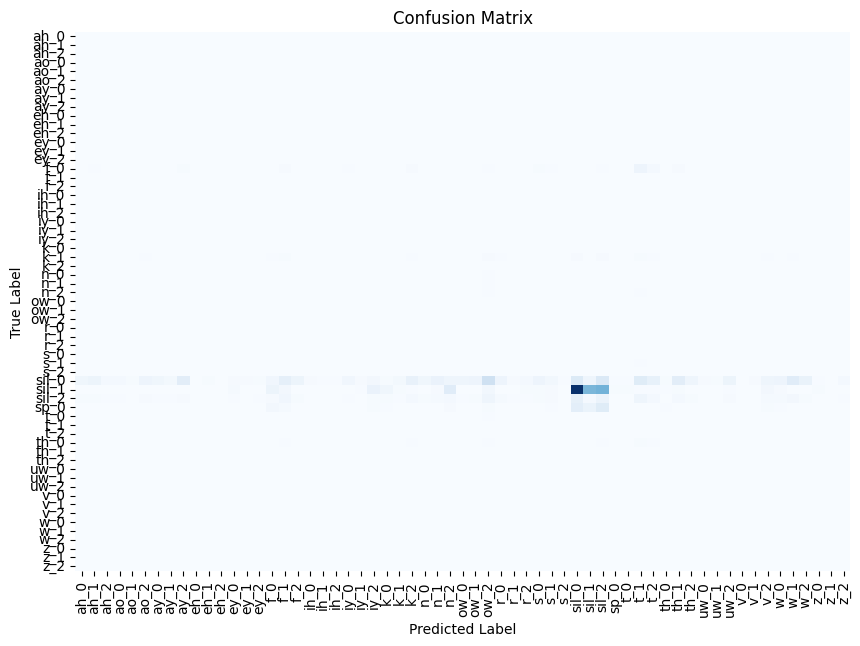

In [19]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=stateList, yticklabels=stateList, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

## 5.1.2 frame-by-frame at the phoneme level

In [20]:
states = set([state.split('_')[0] for state in stateList])
    
phoneme_dict = {state:[] for state in states}
idx2phoneme = {}
for state_idx, state in enumerate(stateList):
    phoneme_dict[state.split('_')[0]].append(state_idx)
    idx2phoneme[state_idx] = state.split('_')[0]
    
phoneme_outputs = [idx2phoneme[int(output)] for output in all_outputs]
phoneme_labels = [idx2phoneme[label] for label in all_labels]
    
correct_cnt = sum(1 for i, output in enumerate(phoneme_outputs) if output == phoneme_labels[i])
test_acc = correct_cnt / len(phoneme_outputs)
logger.info(f'Frame-by-frame at the phoneme level accuracy: {test_acc * 100:.2f}%')
    
unique_phonemes = sorted(set(phoneme_labels))
cm_phoneme = confusion_matrix(phoneme_labels, phoneme_outputs, labels=unique_phonemes)
logger.info(f"Phoneme level confusion matrix:\n{cm_phoneme}")

2024-05-12 15:29:20.870 | INFO     | __main__:<module>:14 - Frame-by-frame at the phoneme level accuracy: 31.80%
2024-05-12 15:29:22.565 | INFO     | __main__:<module>:18 - Phoneme level confusion matrix:
[[  1713    874   2307    104    303    497    137    297    629    789
    2020   1280    254    149      3    818    695    918    261   1502
      53]
 [   843    624   1434     34    184    162     52     49    145    229
    1170    781     75     91      1    371    167    373    132    867
      13]
 [  1638    564   2081     72    356    780    189    551   1003    505
    1188   1148    404    139      4   1838   1136    605    201    943
     138]
 [   897    245   1080     55    143    376    109    299    716    175
     526    370    342     75      8   1245    517    164     83    321
      54]
 [   716    470    882     53    225    359     97    235    352    251
     871    385    203    117      4    913    444    247    129    790
     103]
 [  2545    726   4359   

Text(95.72222222222221, 0.5, 'True Label')

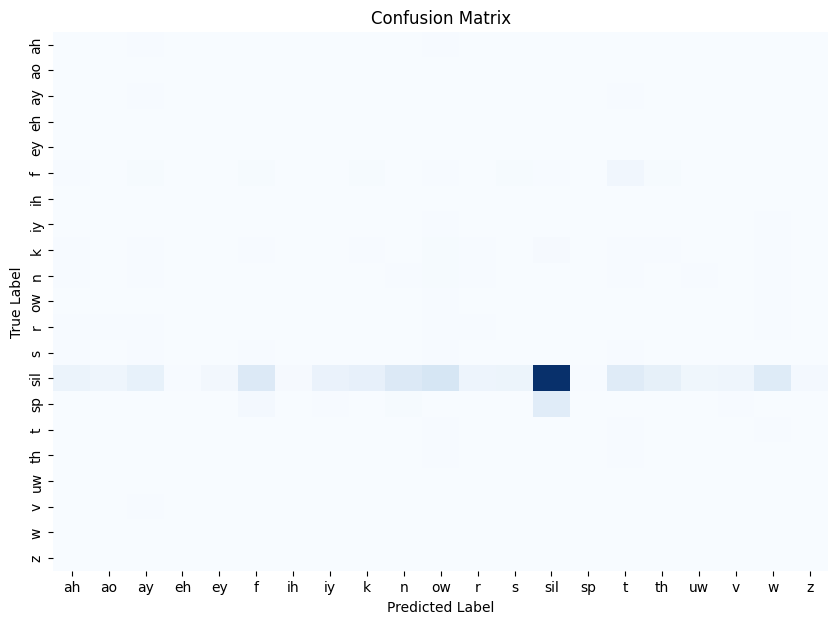

In [21]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm_phoneme, annot=False, fmt='d', cmap='Blues', xticklabels=unique_phonemes, yticklabels=unique_phonemes, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

## 5.1.3 edit distance at state level

In [22]:
per_state = phone_error_rate('state', all_outputs, all_labels, stateList)
print(f"PER at state level: {per_state:.2f}%")

Total 1527014 frames


  0%|          | 0/1527014 [00:00<?, ?it/s]

100%|██████████| 1527014/1527014 [00:02<00:00, 517376.50it/s]

PER at state level: 91.35%


## 5.1.4 edit distance at phoneme level

In [23]:
per_phoneme = phone_error_rate('phoneme', all_outputs, all_labels, stateList, idx2phoneme)
print(f"Phone Error Rate: {per_phoneme:.2f}%")

Total 1527014 frames


100%|██████████| 1527014/1527014 [00:02<00:00, 522103.78it/s]

Phone Error Rate: 68.20%
